# Persuasion scoring

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime,timedelta
tqdm.pandas(desc='Cleaning')

from scorers.cleaning import *
from scorers.persuasion import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Manifestos
manifestos = pd.read_csv('../manifesto-forewords/manifestos.csv')
manifestos.year = pd.to_datetime(manifestos.year)
manifestos = manifestos[manifestos.year>='1900-01-01']
# PMQs answers
pmqs = pd.read_csv('../hansard-pmqs/hansard_pmqs.csv')
pmqs.date = pd.to_datetime(pmqs.date)
pmqs = pmqs[pmqs.date>='1900-01-01']
pmqs = pd.DataFrame({'date':pmqs.groupby(by='date').answer_text.aggregate(lambda x: ''.join(x)).index,
                     'answer_text':pmqs.groupby(by='date').answer_text.aggregate(lambda x: ''.join(x)),
                     'answerer_party':pmqs.groupby(by='date').answerer_party.aggregate(lambda x: x.mode()),
                     'answerer_name':pmqs.groupby(by='date').answerer_name.aggregate(lambda x: x.mode())})
# Conference speeches
conferences = pd.read_csv('../conference-speeches/conference.csv')
conferences.year = conferences.year.apply(lambda year: pd.to_datetime(str(year)+'-01-01'))
conferences = conferences[conferences.year>='1900-01-01']

In [3]:
# Manifestos
manifestos_clean = manifestos.foreword.progress_apply(lambda x: clean(x)) # ...clean them
manifestos_nans = [idx for idx,foreword in enumerate(manifestos_clean) if len(foreword)==0] # ...save NAN indexes to a list
manifestos_scores = [measure_persuasion(foreword) for foreword in tqdm(manifestos_clean,desc='Scoring manifestos') if len(foreword)>0] # ...score them
manifestos_vecs = [list(score_dict.values()) for score_dict in tqdm(manifestos_scores,desc='Saving manifesto scores')] # ...save scores as a list
# PMQs answers
pmqs_clean = pmqs.answer_text.progress_apply(lambda x: clean(x))
pmqs_nans = [idx for idx,answer in enumerate(pmqs_clean) if len(answer)==0]
pmqs_scores = [measure_persuasion(answer) for answer in tqdm(pmqs_clean,desc='Scoring PMQs answers') if len(answer)>0]
pmqs_vecs = [list(score_dict.values()) for score_dict in tqdm(pmqs_scores,desc='Saving PMQs answer scores')]
# Conference speeches
conferences_clean = conferences.content.progress_apply(lambda x: clean(x))
conferences_nans = [idx for idx,speech in enumerate(conferences_clean) if len(speech)==0]
conferences_scores = [measure_persuasion(speech) for speech in tqdm(conferences_clean,desc='Scoring conference speeches') if len(speech)>0]
conferences_vecs = [list(score_dict.values()) for score_dict in tqdm(conferences_scores,desc='Saving conference speech scores')]

Saving conference speech scores: 100%|██████████| 237/237 [00:00<00:00, 15821.77it/s]


Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 232.45it/s]


<Figure size 640x480 with 0 Axes>

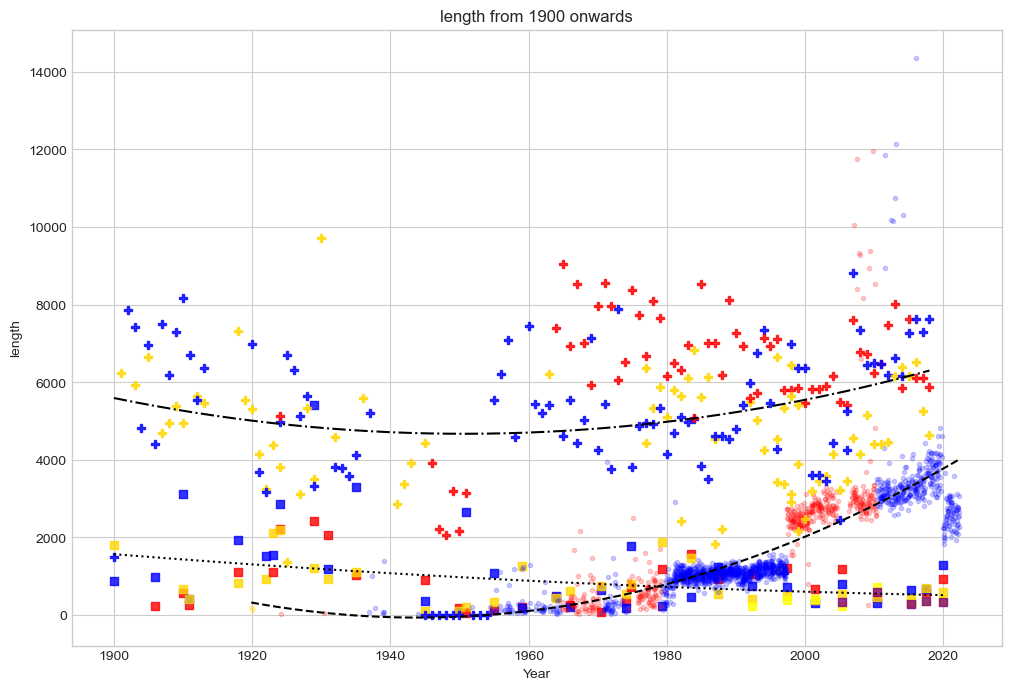

Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 239.07it/s]


<Figure size 640x480 with 0 Axes>

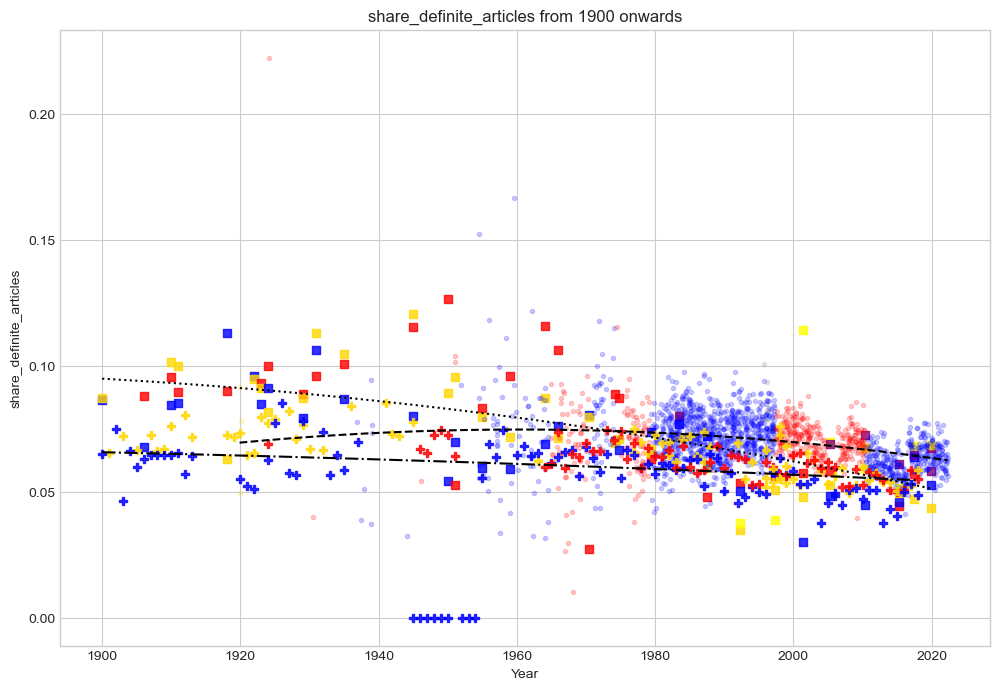

Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 226.18it/s]


<Figure size 640x480 with 0 Axes>

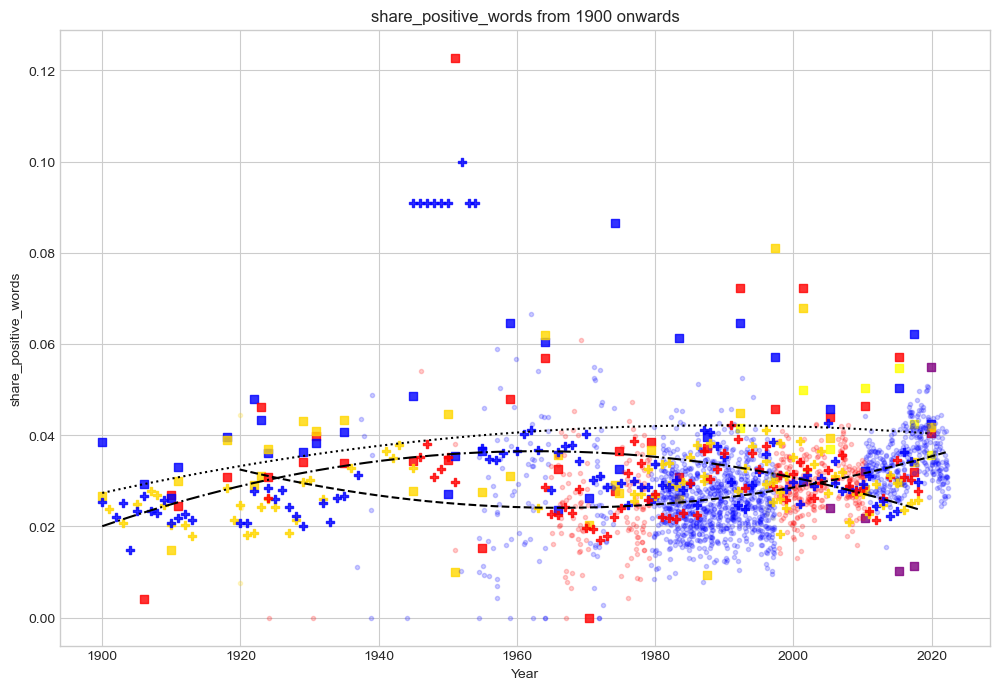

Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 224.40it/s]


<Figure size 640x480 with 0 Axes>

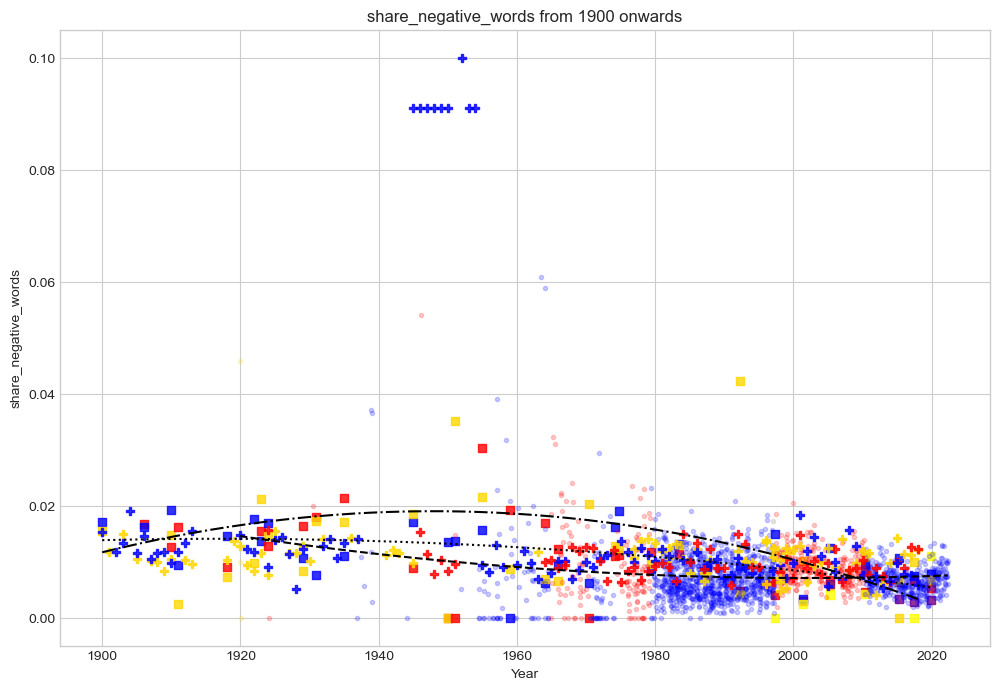

Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 233.90it/s]


<Figure size 640x480 with 0 Axes>

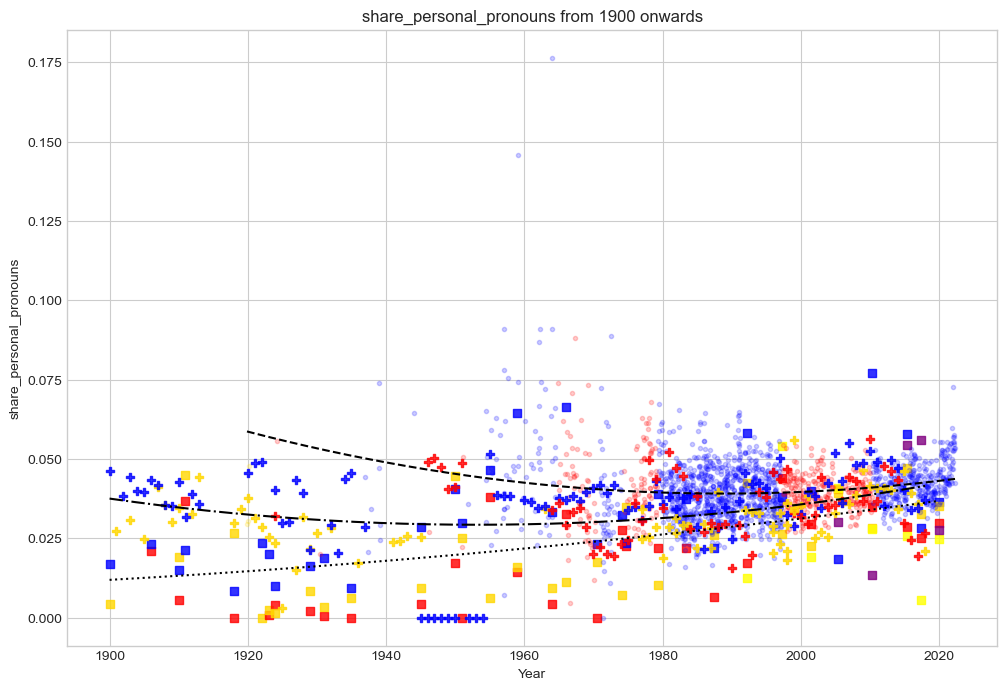

Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 229.65it/s]


<Figure size 640x480 with 0 Axes>

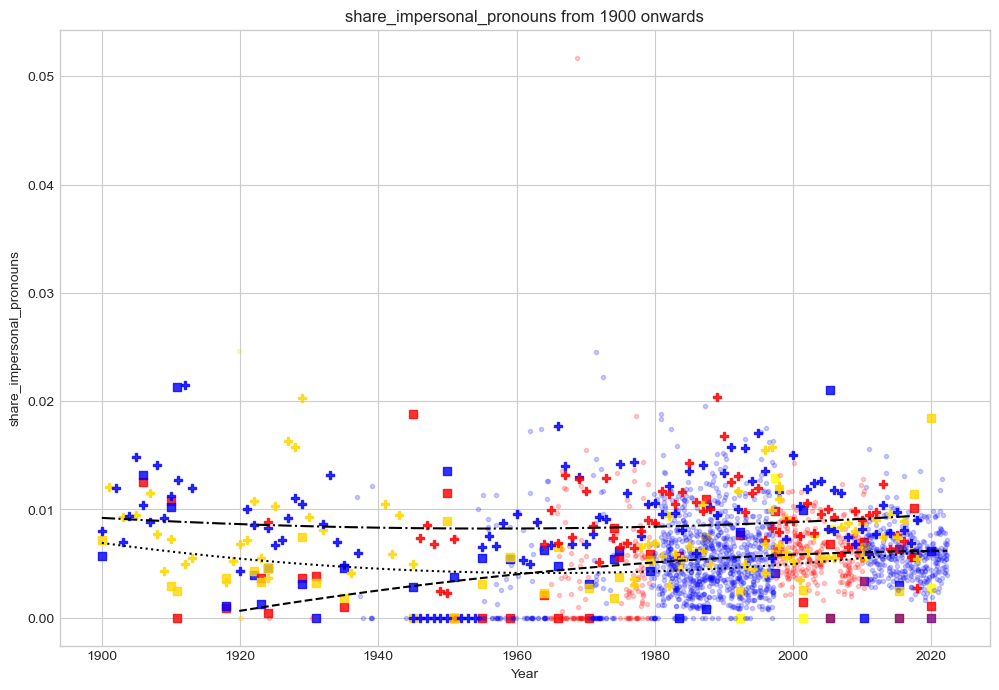

Cleaning: 100%|██████████| 2162/2162 [00:09<00:00, 226.75it/s]


<Figure size 640x480 with 0 Axes>

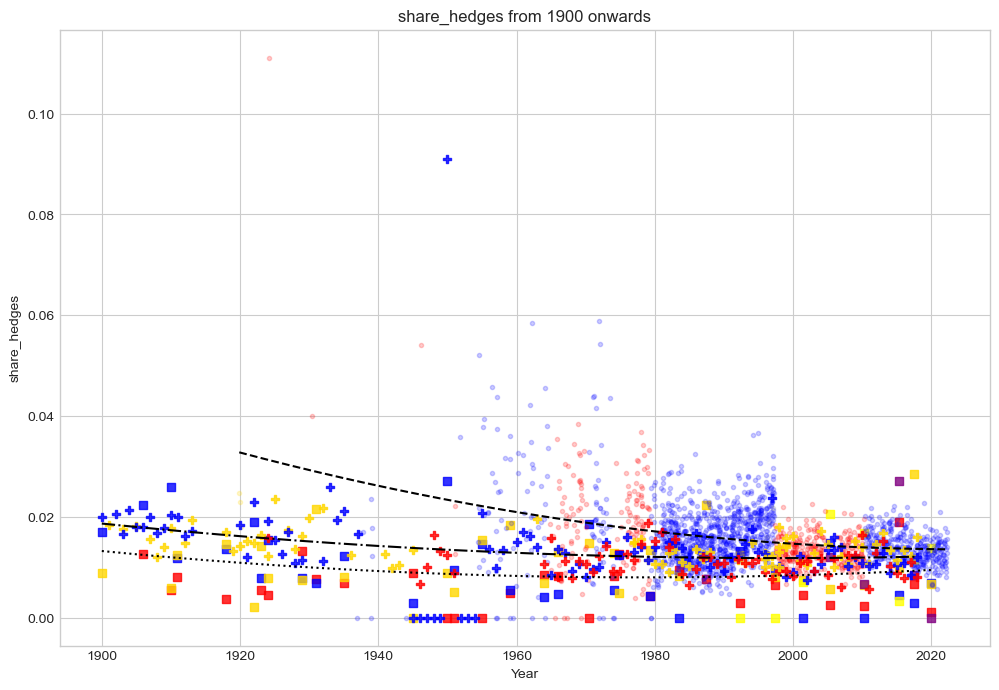

In [4]:
party_dict = {'Labour':'LAB',
              'Conservative':'CON',
              'Liberal':'LIB',
              'SDP-Liberal Alliance':'LIB',
              'Liberal Democrat':'LIB',
              np.nan:'NAN'}



for s_idx,scoring_var in enumerate(manifestos_scores[0].keys()):
    plt.clf()
    manifestos_df = pd.DataFrame({'score':[x[s_idx] for x in manifestos_vecs],
                                  'type':['manifesto']*len(manifestos_vecs),
                                  'year':manifestos.drop(manifestos_nans, axis=0).year,
                                  'party':manifestos.drop(manifestos_nans, axis=0).party})
    pmqs_df = pd.DataFrame({'score':[x[s_idx] for x in pmqs_vecs],
                           'type':['PMQs']*len(pmqs_vecs),
                           'year':pmqs.drop(pmqs_nans, axis=0).date,
                           'party':pmqs.drop(pmqs_nans, axis=0).answerer_party.apply(lambda party: party_dict[str(party)] if str(party) in party_dict.keys() else 'NAN')})
    conferences_df = pd.DataFrame({'score':[x[s_idx] for x in conferences_vecs],
                                   'type':['conference']*len(conferences_vecs),
                                   'year':conferences.drop(conferences_nans, axis=0).year,
                                   'party':conferences.drop(conferences_nans, axis=0).party.apply(lambda party: party_dict[party])})
    var_df = pd.DataFrame({'score':[],'type':[],'year':[],'party':[]})
    var_df = var_df.append(manifestos_df)
    var_df = var_df.append(pmqs_df)
    var_df = var_df.append(conferences_df)

    col_dict = {'LAB':'red','CON':'blue','LIB':'gold','SNP':'yellow','UKIP':'purple','BRX':'purple','NAN':'grey'}
    marker_dict = {'manifesto':'s','PMQs':'.','conference':'P'}
    alpha_dict = {'manifesto':0.8,'PMQs':0.2,'conference':0.8}

    plt.style.use('seaborn-whitegrid')
    fig,ax = plt.subplots(1, figsize=(12,8))
    var_df.progress_apply(lambda row: ax.scatter(row.year, row.score,
                                                              color=col_dict[row.party],
                                                              marker=marker_dict[row.type],
                                                              alpha=alpha_dict[row.type]),
                                       axis=1)

    # Plot line of best fit for manifestos
    deg = 2
    x = np.array([date for date in manifestos.drop(manifestos_nans, axis=0).year])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    y = np.array([score_dict[scoring_var] for score_dict in manifestos_scores])
    coefs = np.polyfit(native_x, y, deg=deg)
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    ax.plot(pd.to_datetime(xseq), yseq, ':', color='black')
    # ...PMQs
    x = np.array([date for date in pmqs.drop(pmqs_nans, axis=0).date])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    y = np.array([score_dict[scoring_var] for score_dict in pmqs_scores])
    coefs = np.polyfit(native_x, y, deg=deg)
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    ax.plot(pd.to_datetime(xseq), yseq, '--', color='black')
    # ...and conference speeches
    x = np.array([date for date in conferences.drop(conferences_nans, axis=0).year])
    native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
    y = np.array([score_dict[scoring_var] for score_dict in conferences_scores])
    coefs = np.polyfit(native_x, y, deg=deg)
    xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
    XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
    yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
    ax.plot(pd.to_datetime(xseq), yseq, '-.', color='black')
    ax.set_xlabel("Year")
    ax.set_ylabel(scoring_var)
    ax.set_title(scoring_var+" from 1900 onwards")
    plt.show()